Importing libraries

In [1]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

In [2]:

from utils.load_data import get_exp_data
from utils.parameters import params 
params = params()
from utils.potential_gradient import _dU_dc_anode


ModuleNotFoundError: No module named 'parameters'

Uploading experimental data

In [29]:
'''
# at ca. 45% SoC (3.587 V)
# at 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02_EIS-SoC/MJ1_02_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    #df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    #name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq, len(freq)] #, df_name]

'''


'\n# at ca. 45% SoC (3.587 V)\n# at 25 deg C\n\ndef get_exp_data(i, d): \n    z_list = []\n    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02_EIS-SoC/MJ1_02_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"\n    ca = Impedance(file)\n    ca.load(filename=file)\n\n    # extract EIS curve\n    res = ca.get_curve_data().iloc[::-1]\n    df_real = res[\'Zreal\']\n    df_imag= res[\'Zimag\']\n    df_freq = res[\'Freq\']\n    #df_name = res[\'Vdc\']\n\n    # Removing the points beneath the y-axis \n    real = df_real[df_imag <= 0]\n    imag = df_imag[df_imag <= 0]\n    freq = df_freq[df_imag <= 0]\n    \n    #name = sum(df_name)/len(df_name)\n    # Adding the impendances to the list \n    z_list.append(real)\n    z_list.append(imag)\n    return[z_list, freq, len(freq)] #, df_name]\n\n'

Function to get detailed information on V (SOC should be around 45%)

In [30]:
''''
def get_vdc(i, d): 
    length = get_exp_data(i, d)[2]
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    df = pd.read_csv(file, delimiter='\t', skiprows=[i for i in range(0, 60)], encoding='ISO-8859-1')

    df_vdc = df['Vdc'][::-1]
    vdc = df_vdc[:length+1]
    v_list = np.array(vdc)

    sum = 0 
    for i in v_list: 
        sum += float(i) 
    v_avg = sum/len(v_list)

    return v_avg #, df_name]

get_vdc(1, "")

'''

'\'\ndef get_vdc(i, d): \n    length = get_exp_data(i, d)[2]\n    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"\n    df = pd.read_csv(file, delimiter=\'\t\', skiprows=[i for i in range(0, 60)], encoding=\'ISO-8859-1\')\n\n    df_vdc = df[\'Vdc\'][::-1]\n    vdc = df_vdc[:length+1]\n    v_list = np.array(vdc)\n\n    sum = 0 \n    for i in v_list: \n        sum += float(i) \n    v_avg = sum/len(v_list)\n\n    return v_avg #, df_name]\n\nget_vdc(1, "")\n\n'

## Parameters from Amund

(I have only changed the electrolyte conductivity)

In [31]:
'''
# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * np.exp(-p[1] * x)
            + p[2]
            - p[3] * np.tanh(p[4] * (x - p[5]))
            - p[6] * np.tanh(p[7] * (x - p[8]))
            - p[9] * np.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * np.tanh(p[3] * (x - p[4]))
            - p[5] * np.tanh(p[6] * (x - p[7]))
            + p[8] * np.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,
    'EC initial concentration in electrolyte [mol.m-3]': 1000,  #4541.0,

 # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,

    # end of table data
    }

# Use default parameters from the Chen2020 publication
params = pybamm.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value: # Check if the parameter exists in 'params' and has a different value
            params[parameter] = value # Update 'params' with the new value from 'literature_params'
    except KeyError as e: # This block handles the case where the 'parameter' is not in 'params'
        print(f"Parameter {parameter} not part of default. Skipping.")

#params['Electrolyte conductivity']

'''


'\n# OCV curves for the anode and cathode\n# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium\ndef MJ1_ocp_tanh_SiC(sto):\n    x = sto\n    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])\n    \n    return (\n            p[0] * np.exp(-p[1] * x)\n            + p[2]\n            - p[3] * np.tanh(p[4] * (x - p[5]))\n            - p[6] * np.tanh(p[7] * (x - p[8]))\n            - p[9] * np.tanh(p[10] * (x - p[11]))\n        )\n\ndef MJ1_ocp_tanh_NMC(sto):\n    x = sto\n    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])\n\n    return (\n            -p[0] * x\n            + p[1]\n            - p[2] * np.tanh(p[3] * (x - p[4]))\n            - p[5] * np.tanh(p[6] *

### Finding the $-\frac{\partial U}{\partial c_s}$ for each the anode and the cathode

In [ ]:
'''
c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_n_s_max = c_n_max 
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]
c_p_s_max = c_p_max

params.set_initial_stoichiometries(0.45) # Setting SOC, this changes the initial concentrations
c_n = params['Initial concentration in negative electrode [mol.m-3]'] 
c_n_s = c_n # for the surface of the particle
c_p = params['Initial concentration in positive electrode [mol.m-3]'] 
c_p_s = c_p

'''


In [ ]:
'''
def sech_2(z): 
    return 1/np.cosh(z)**2

def _dU_dc_anode(c): 
    x = c/c_n_max
    # Har satt in for x i uttrykket for potensial lenger oppe og derivert med hensyn på c
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    dU_dc = -(p[6]*p[7]*sech_2(p[7]*(c/c_n_max-p[8])))/c_n_max - (p[3]*p[4]*sech_2(p[4]*(c/c_n_max-p[5])))/c_n_max - (p[9]*p[10]*sech_2(p[10]*(c/c_n_max-p[11])))/c_n_max - (p[0]*p[1]*np.exp(-p[1]*c/c_n_max))/c_n_max
    return -dU_dc # [V*m^3/mol]

_dU_dc_a = _dU_dc_anode(c_n)

def _dU_dc_cathode(c): 
    x = c/c_p_max
    # Har satt in for x i uttrykket for potensial lenger oppe og derivert med hensyn på c
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])
    dU_dc = -(p[5]*p[6]*sech_2(p[6]*(c/c_p_max-p[7])))/c_p_max - (p[2]*p[3]*sech_2(p[3]*(c/c_p_max-p[4])))/c_p_max + (p[9]*p[8]*sech_2(p[9]*(c/c_p_max-p[10])))/c_p_max - p[0]
    return -dU_dc # [V*m^3/mol]

_dU_dc_c = _dU_dc_cathode(c_p)
'''


### Diverse utregninger 

In [ ]:
'''
F = 96485 #C/mol 
R = 8.314 #J/mol*K
n = 1 
T = 298 # K

'''

In [ ]:
'''
volume_anode = params['Electrode height [m]']*params['Electrode width [m]']*params['Negative electrode thickness [m]'] # [m^3]
volume_cathode = params['Electrode height [m]']*params['Electrode width [m]']*params['Positive electrode thickness [m]'] # [m^3]
area_electrode = params['Electrode height [m]']*params['Electrode width [m]'] #[m^2]

c_e = params['EC initial concentration in electrolyte [mol.m-3]']
i_0_a = params['Negative electrode exchange-current density [A.m-2]'](c_e, c_n_s, c_n_s_max, T)
i_0_c = params['Positive electrode exchange-current density [A.m-2]'](c_e, c_p_s, c_p_s_max, T)

r_a = params['Negative particle radius [m]']
r_c = params['Positive particle radius [m]']
e_a = 1 - params['Negative electrode porosity']
e_c = 1 - params['Positive electrode porosity']
'''

Functions to convert list to dictionary or vice versa 

In [ ]:
'''
# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))
'''

#### Equation for finding $R_{ct}$ from the given exchange current density parameter: 

The charge transfer resistances (= $R_{ct}$), $R1$ and $R2$, are found from the Butler-Volmer equation: 

$$R_{ct} = \frac{RT}{n\cdot i_0(\alpha_a + \alpha_c)F}, $$

at small overpotentials and assuming a symmetrical charge transfer process $(\alpha_a + \alpha_c = 1)$. This equation is also written as equation $(20)$ in the Meyers paper. 

In [ ]:
'''
def R_ct(i_0): 
    return (R*T)/(n*F*i_0) # [ohm.m^2]

R1_a = R_ct(i_0_a).__dict__['_value']
R1_c = R_ct(i_0_c).__dict__['_value']
'''

#### Equation for finding the pore surface volume divided by the electrode volume (=$a$):

The pore surface area can be found from the following calculations: 

$$V_{particle} = \frac{4\pi r^3}{3}$$
$$V_{active} = \epsilon \cdot V_{electrode}, $$

where $\epsilon$ is the fraction of active electrode material and then $V_{active}$ is the volume of the active electrode material. This gives the number of particles $N = \frac{V_{active}}{V_{particle}}$. Further, the surface area of one particle is 

$$A_{particle} = 4 \pi r^2, $$

so that $A_{total} = N\cdot A_{particle}$, where $A_{total}$ is the total pore/particle surface area. 

Then $a$ is calculated from 

$$a = \frac{A_{total}}{V_{electrode}}$$




In [ ]:
'''
N = e_a*volume_anode/((4*np.pi/3)*r_a**3)

def a(V_electrode, e): 
    V_particle = (4*np.pi/3)*r_a**3
    V_active = e*V_electrode 
    # Number of particles
    N = V_active/V_particle 
    # Surface area of particle 
    A_particle = 4*np.pi*r_a**2
    # Total surface area of particles
    A_total = N*A_particle # so that A_total = (3*e)/r_particle
    return A_total/V_electrode # [m^-1]


print(a(volume_anode, e_a))

print(3*e_a/r_a)
'''

385573.7704918033
385573.77049180336


## Meyers parametre

+ $R1$ - resistance 
+ $R2$ - resistance 
+ $C1$ - capicitance 
+ $C2$ - capicitance 
+ $R_s$ - particle size (assuming radius)
+ $D_s$ - diffusion coefficient 
+ $a$ - surface area of pores per volume electrode
+ $L$ - electrode thickness
+ $K$ - electrolyte conductivity 
+ $\sigma$ - electrode conductivity 
+ $\epsilon$ - porosity 
+ $\left(-\frac{\partial U}{\partial c_s}\right)$

These parameters are defined from the given parameters by Amund (above). If the Meyer parameter does not have an equivalent in the parameter list above, it is calculated from relations (for example, the resistances $R1$ and $R2$ are calculated from the exhange current density $i$). 

Fra Ann-Mari sine anbefalinger har jeg ikke inkludert R1 og R2 i førsteomgang. 

In [ ]:
'''
a_parametre = {
    "R1": R1_a,  # motstand, [ohm.m^2]
    "C1": params['Negative electrode double-layer capacity [F.m-2]'],  # kapasitans
    "Rs": params['Negative particle radius [m]'], # partikkelstørrelse, [F.m^-2]
    "Ds": params['Negative electrode diffusivity [m2.s-1]'],     # diffusjonskoeffisient [m^2.s^-1]
    "a": a(volume_anode, e_a),  # overflateareal porer/volum electrode [m^-1]
    "L": params['Negative electrode thickness [m]'],  # tykkelse, elektrode, [m]
    "K" : params['Electrolyte conductivity [S.m-1]'](c_e, T),  # ledningsevne elektrolytt [S.m^-1]
    "sigma": params['Negative electrode conductivity [S.m-1]'], # ledningsevne, fast elektrodematerial [S.m^-1]
    "ebsilon": e_a,     # volume fraction anode
    "-dU_dcs": _dU_dc_a, #[V.m^3.mol-1]
    }

c_parametre = {
    "R1": R1_c,  # motstand
    "C1": params['Positive electrode double-layer capacity [F.m-2]'],  # kapasitans
    "Rs": params['Positive particle radius [m]'], # partikkelstørrelse
    "Ds": params['Positive electrode diffusivity [m2.s-1]'],     # diffusjonskoeffisient 
    "a": a(volume_cathode, e_c),  # overflateareal porer/volum electrode 
    "L": params['Positive electrode thickness [m]'],  # tykkelse, elektrode
    "K" : params['Electrolyte conductivity [S.m-1]'](c_e, T),  # ledningsevne elektrolytt 
    "sigma": params['Positive electrode conductivity [S.m-1]'], # ledningsevne, fast elektrodematerial 
    "ebsilon": e_c,     # volume fraction cathode
    "-dU_dcs": _dU_dc_c, 
    }

print(a_parametre)
print(c_parametre)
#params.search('Positive particle surface concentration [mol.m-3]')

'''

{'R1': 0.07825704835882585, 'C1': 0.2, 'Rs': 6.1e-06, 'Ds': 5e-14, 'a': 385573.7704918033, 'L': 8.67e-05, 'K': 0.9487000000000005, 'sigma': 100.0, 'ebsilon': 0.784, '-dU_dcs': 1.3786045384026093e-05}
{'R1': 0.0076328858714558205, 'C1': 0.2, 'Rs': 3.8e-06, 'Ds': 5e-13, 'a': 407704.9180327869, 'L': 6.62e-05, 'K': 0.9487000000000005, 'sigma': 0.17, 'ebsilon': 0.829, '-dU_dcs': 0.740426330458689}


## Calculate impedance (from Meyers paper)

$$R_{part} = \left(-\frac{\partial U}{\partial c_s}\right)\frac{R_s}{FD_s}$$

$$Y_s = \frac{\sqrt{j\Omega_s}-\tanh(\sqrt{j\Omega_s})}{\tanh(\sqrt{j\Omega_s})},$$

where $Y_s$ is the admittance for the diffusion effect and $\Omega_s$ is the dimensionless frequency: 

$$\Omega_s = \frac{\omega R_s^2}{D_s^{a}}$$

Further, 

$$Y(\omega) = \frac{1}{\frac{R1 + \frac{R_{part}}{Y_s}}{1 + j\omega C1\left(R1 + \frac{R_{part}}{Y_s}\right)} + \frac{R2}{1+j\omega R2\cdot C2}}, $$

where $Y(\omega)$ is the admittance (intercalation, BV-kinetics and double-layer capacitance) of a single particle at a given frequency. $\overline{aY}$ is the average admittance in the porous electrode. 

$$v = \frac{L}{\left(\frac{K\sigma}{K + \sigma}\right)^{\frac{1}{2}}\left({\overline{aY}}\right)^{-\frac{1}{2}}}, $$

where the parameter $v$ is a function of frequency $\omega$ and is determined for set values of $\sigma$ and $K$. 
Finally, the total impedance is given by

$$Z = \frac{L}{K+\sigma}\left[1 + \frac{2 + (\frac{\sigma}{K} + \frac{K}{\sigma})\cosh v}{v\cdot \sinh v}\right]$$




In [ ]:
'''
def R_part(param): 
    R_part = _dU_dc_a*(param['Rs']/(F*param['Ds']))
    return R_part 

def Y_s(param, ang_freq):
    omega_s = (ang_freq*param['Rs']**2)/param['Ds']
    Y_s = (np.sqrt(1j*omega_s) - np.tanh(np.sqrt(1j*omega_s)))/np.tanh(np.sqrt(1j*omega_s))
    return Y_s

def Y_particle(param, ang_freq, R_part, Y_s): 
    Y = 1/((param['R1'] + R_part/Y_s)/(1 + 1j*ang_freq*param['C1']*(param['R1'] + R_part/Y_s)))
    return Y

def v(param, Y): 
    v = param['L']/ (((param['K']*param['sigma'])/(param['K'] + param['sigma']))**0.5*((param['a']*Y))**(-0.5))
    return v

'''

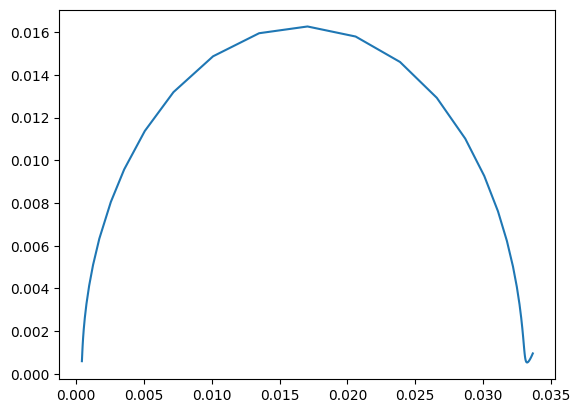

In [ ]:
'''
# Function to calculate Z 
def calc_Z(comp, frequencies):
    # Update param dictionary from the flat parameter list (comp), where comp is updated values
    param = list_to_dict(a_parametre, comp) 
    ang_freq = 2 * np.pi * frequencies

    Rp = R_part(param)
    Ys = Y_s(param, ang_freq)
    Y = Y_particle(param, ang_freq, Rp, Ys)
    v_calc = v(param, Y)

    # The total impedance: 
    Z = (param['L']/(param['K']+param['sigma']))*(1 + (2 + (param['sigma']/param['K'] + param['K']/param['sigma'])*np.cosh(v_calc))/(v_calc*np.sinh(v_calc)))
    
    return Z/area_electrode

frequencies = np.array(get_exp_data(1, "")[1])
Z_init = calc_Z(dict_to_list(a_parametre), frequencies)
plt.plot(Z_init.real, -Z_init.imag)
plt.show()

'''

In [ ]:
'''
# Optimizing the difference function for a given data set
def optimize_diff(i, parametre):
    # Load the experimental data 
    exp_real = np.array(get_exp_data(i, "")[0][0])
    exp_imag = np.array(get_exp_data(i, "")[0][1])
    frequencies = np.array(get_exp_data(i, "")[1])

    # Difference function for the optimization
    def diff_func(comp, exp_real, exp_imag, frequencies):
        Z = calc_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff
    
    #print(diff_func(dict_to_list(a_number_parametre), exp_real, exp_imag, frequencies))

    # Convert initial dictionary to list for optimization
    initial_elems = dict_to_list(parametre)

    # Optimization options
    options = {
        'maxiter': 10000,    # Maximum number of iterations
        'ftol': 1e-4,       # Function value tolerance
        #'disp': True
    }

    # Minimize the difference function (optimize parameters)
    opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag, frequencies), method='TNC', options=options)
    opt_elems = list_to_dict(parametre, opt.x)
    final_diff = diff_func(opt.x, exp_real, exp_imag, frequencies)
    
    #print("Final sum of squared difference for dataset", i, ":", final_diff)

    return opt_elems, final_diff, frequencies, opt.x 

# Example usage: optimize for a specific dataset (choose i from 1 to 5)
i = 1 # Change i to the desired dataset index
dic_elems, final_diff, frequencies, list_elems = optimize_diff(i, a_parametre)

print(final_diff)
print(dic_elems)
print(a_parametre)

'''

0.019025233831010006
{'R1': 0.07825704835882585, 'C1': 0.2, 'Rs': 6.099999999997029e-06, 'Ds': 2.1576496441636004e-14, 'a': 385573.7704918033, 'L': 8.669999999972467e-05, 'K': 0.9487000000000005, 'sigma': 100.0, 'ebsilon': 0.784, '-dU_dcs': 1.3786045384026093e-05}
{'R1': 0.07825704835882585, 'C1': 0.2, 'Rs': 6.1e-06, 'Ds': 5e-14, 'a': 385573.7704918033, 'L': 8.67e-05, 'K': 0.9487000000000005, 'sigma': 100.0, 'ebsilon': 0.784, '-dU_dcs': 1.3786045384026093e-05}


In [8]:
from utils.convertion import dict_to_list, list_to_dict
from utils.ecm_randles import calc_Z, c_elem
from utils.ecm_meyers import calculate_Z, a_fitting
from utils.optimize import optimize_diff

optimize_diff(1, c_elem, calc_Z)

({'R_el': 0.026311026572117147,
  'L': 4.708712711878579e-07,
  'R_ct1': 0.006056965817144911,
  'Q1': 0.6843045310832762,
  'alpha1': 0.680805468634486,
  'A1': 0.002195440372399166,
  'a_w1': 0.5880856046008839,
  'R_ct2': 0.0035155345043565234,
  'Q2': 2.3792865699710406,
  'alpha2': 0.8549206996738854},
 3.270192154328697e-06,
 array([1.000110e-02, 1.259070e-02, 1.585220e-02, 1.995530e-02,
        2.512060e-02, 3.162960e-02, 3.982580e-02, 5.013370e-02,
        6.317390e-02, 7.944920e-02, 1.001603e-01, 1.260081e-01,
        1.588983e-01, 2.003205e-01, 2.520161e-01, 3.167230e-01,
        4.006410e-01, 5.040323e-01, 6.334459e-01, 7.923428e-01,
        9.990410e-01, 1.266892e+00, 1.584686e+00, 1.998082e+00,
        2.504006e+00, 3.158693e+00, 3.945707e+00, 5.008013e+00,
        6.317385e+00, 7.944915e+00, 9.931140e+00, 1.240079e+01,
        1.562500e+01, 1.986229e+01, 2.493351e+01, 3.125000e+01,
        3.842213e+01, 5.022321e+01, 6.334460e+01, 7.900281e+01,
        1.004464e+02, 1.255

PSO

In [47]:

i = 1
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])
frequencies = np.array(get_exp_data(i, "")[1])

# Difference function for the optimization
def diff_func(comp, exp_real, exp_imag, frequencies):
    Z = calc_Z(comp, frequencies)
    diff_real = Z.real - exp_real
    diff_imag = Z.imag - exp_imag
    sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
    return sum_square_diff

def wrapped_diff_func(comp):
  return np.array([diff_func(par, exp_real, exp_imag, frequencies) for par in comp])

n_dim = len(a_parametre) #changing 

options = {
    'c1': 0.5, 
    'c2': 0.3, 
    'w': 0.9,
}

optimizer = ps.single.GlobalBestPSO(n_particles = 100, dimensions = n_dim, options = options)

best_cost, best_params = optimizer.optimize(wrapped_diff_func, iters =100)

print(best_cost)
print(best_params)

2024-11-26 20:21:56,068 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.000901
2024-11-26 20:21:58,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0009009492374866769, best pos: [3.77682828e-05 2.58627533e+00 4.96012055e+00 3.48467423e+00
 4.40574882e+00 9.55792123e-03 3.41442422e+00 4.41872780e+00
 2.91200900e+00 2.09835158e+00]


0.0009009492374866769
[3.77682828e-05 2.58627533e+00 4.96012055e+00 3.48467423e+00
 4.40574882e+00 9.55792123e-03 3.41442422e+00 4.41872780e+00
 2.91200900e+00 2.09835158e+00]


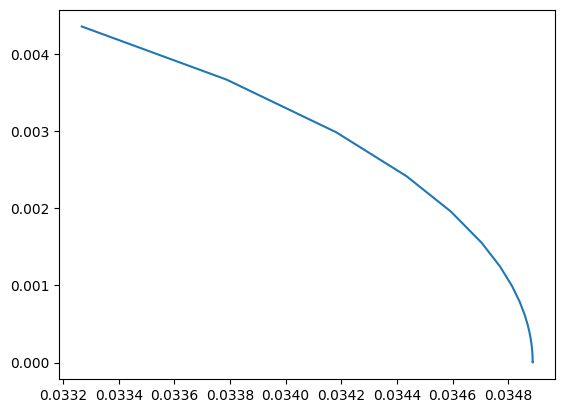

In [48]:
frequencies = np.array(get_exp_data(1, "")[1])
Z_opt = calc_Z(best_params, frequencies)

plt.plot(Z_opt.real, -Z_opt.imag)
plt.show()

Observe how the parameters are changing with degradation

In [49]:
def finding_params(): 
    dic_list = []
    for l in range(1,5):
        dic_elems, final_diff, frequencies, list_elems = optimize_diff(l)
        dic_list.append(dic_elems)
    
    combined_dict = {}
    
    for d in dic_list:
        for key, value in d.items():
            # If key is not in combined_dict, initialize with empty list
            if key not in combined_dict:
                combined_dict[key] = []
            # Append the value to the list for this key
            combined_dict[key].append(value)

    return combined_dict

In [46]:
combined_dict = finding_params()

def plot_change_param(key_list): 
    x = [1, 2, 3, 4]
    fig, ax = plt.subplots(figsize=(6, 6)) 
    for key in key_list: 
        ax.scatter(x, combined_dict[key], label = key)

    plt.legend()
    plt.xlabel("Data Set Number")
    plt.ylabel("Parameter Value")
    plt.title("Change in Parameters") 
    plt.show()

#plot_change_param(['R1', 'R2'])
#plot_change_param(['Rs', 'Ds'])
#plot_change_param(['C1', 'C2'])
#plot_change_param(['a', 'L'])
#plot_change_param(['K', 'sigma'])
#plot_change_param(['ebsilon'])


TypeError: optimize_diff() missing 1 required positional argument: 'parametre'

Comparison plot

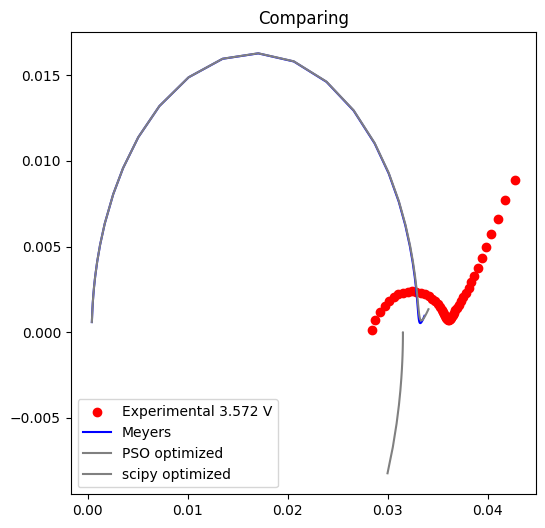

In [ ]:
frequencies = np.array(get_exp_data(1, "")[1])
Z = calc_Z(dict_to_list(a_parametre), frequencies)
Z_scipy = calc_Z(list_elems, frequencies)
Z_pso = calc_Z(best_params, frequencies)

fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.plot(Z.real, -Z.imag, label = f'Meyers', color = 'blue')
ax.plot(Z_pso.real, -Z_pso.imag, label = f'PSO optimized', color = 'grey')
ax.plot(Z_scipy.real, -Z_scipy.imag, label = f'scipy optimized', color = 'grey')


#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

# Dataset 1: Fitting R1, C1, Ds and a to experimental data

In [ ]:
'''
a_fitting = {
    "Rel": 0.002, # motstand elektrolytt, [ohm.m^2]
    "R1": 0.02,  # motstand, [ohm.m^2]
    "Q1": 0.75,  # kapasitans
    "alpha": 0.8,
    "Ds": 2e-16,     # diffusjonskoeffisient [m^2.s^-1]
    "alpha2": 0.8, #ikke-ideell diffusjon
    "a": 618947,  # overflateareal porer/volum electrode [m^-1]
    }
'''


a_fitting = {
    "Rel": 0.00202, # motstand elektrolytt, [ohm.m^2]
    "R1": 0.01,  # motstand, [ohm.m^2]
    "R2": 0.008, 
    "Q1": 0.9,  # kapasitans
    "Q2": 0.9, 
    "alpha_q1": 0.75,
    "alpha_q2": 0.8,
    "Ds": 4.1e-15,     # diffusjonskoeffisient [m^2.s^-1]
    "alpha": 0.93, #ikke-ideell diffusjon
    "a": 428947,  # overflateareal porer/volum electrode [m^-1]
    }


Rs_a = params['Negative particle radius [m]']
L_a = params['Negative electrode thickness [m]'] 
sigma_a = params['Negative electrode conductivity [S.m-1]'] 
epsilon_a = e_a # volume fraction anode
K_a = (params['Electrolyte conductivity [S.m-1]'](c_e, T)*epsilon_a)/params['Negative electrode Bruggeman coefficient (electrolyte)']

i = 1


### Regner ut impedansen 

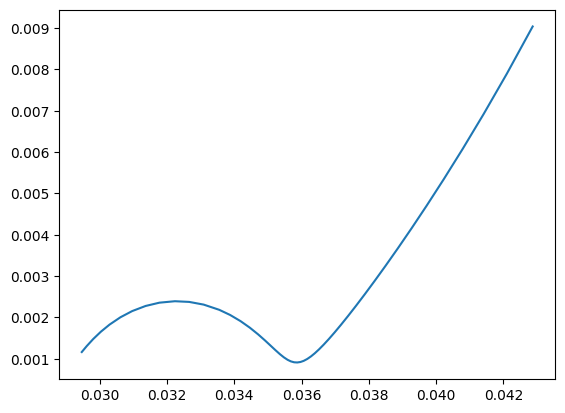

In [ ]:
def R_part(Ds): 
    R_part = _dU_dc_a*(Rs_a/(F*Ds))
    return R_part 

def Y_s(omega, Ds, alpha):
    omega_s = (omega*Rs_a**2)/Ds**alpha
    Y_s = (np.sqrt(1j*omega_s) - np.tanh(np.sqrt(1j*omega_s)))/np.tanh(np.sqrt(1j*omega_s))
    return Y_s

def Y_particle(omega, R1, R2, Q1, Q2, alpha_q1, alpha_q2, R_part, Y_s): 
    Y = 1/((R1 + R_part/Y_s)/(1 + (1j*omega)**alpha_q1*Q1*(R1 + R_part/Y_s)) + R2/(1 + (1j*omega)**alpha_q2*Q2*R2))
    return Y

def v(a, Y): 
    v = L_a/ (((K_a*sigma_a)/(K_a + sigma_a))**0.5*((a*Y))**(-0.5))
    return v

# Function to calculate Z 
def calculate_Z(comp, frequencies):
    # Update param dictionary from the flat parameter list (comp), where comp is updated values
    param = list_to_dict(a_fitting, comp) 
    ang_freq = 2 * np.pi * frequencies

    Rp = R_part(param['Ds'])
    Ys = Y_s(ang_freq, param['Ds'], param['alpha'])
    Y = Y_particle(ang_freq, param['R1'], param['R2'], param['Q1'], param['Q2'], param['alpha_q1'], param['alpha_q2'], Rp, Ys)
    v_calc = v(param['a'], Y)

    # The total impedance: 
    Z = param['Rel'] + (L_a/(K_a+sigma_a))*(1 + (2 + (sigma_a/K_a + K_a/sigma_a)*np.cosh(v_calc))/(v_calc*np.sinh(v_calc)))
    
    return Z/area_electrode

frequencies = np.array(get_exp_data(1, "")[1])
Z_init = calculate_Z(dict_to_list(a_fitting), frequencies)
plt.plot(Z_init.real, -Z_init.imag)
plt.show()

### Prøver én kalkuleringsfunksjon

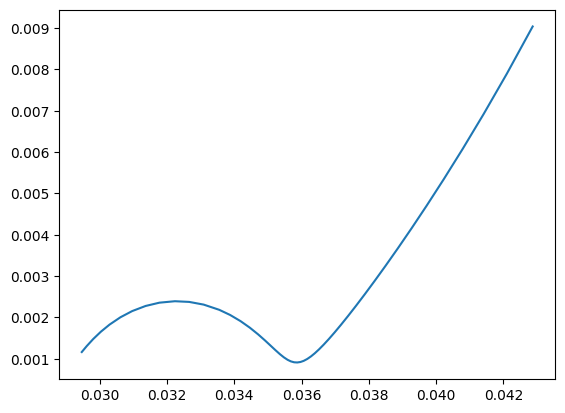

In [ ]:
def calc_Zen(comp_a, frequencies):
    # Update param dictionary from the flat parameter list (comp), where comp is updated values
    param_a = list_to_dict(a_fitting, comp_a) 
    ang_freq = 2 * np.pi * frequencies

    Rp_a = _dU_dc_a*(Rs_a/(F*param_a['Ds']))
    omegas_a = (ang_freq*Rs_a**2)/param_a['Ds']**param_a['alpha']
    Ys_a = (np.sqrt(1j*omegas_a) - np.tanh(np.sqrt(1j*omegas_a)))/np.tanh(np.sqrt(1j*omegas_a))
    Y_a = 1/((param_a['R1'] + Rp_a/Ys_a)/(1 + (1j*ang_freq)**param_a['alpha_q1']*param_a['Q1']*(param_a['R1'] + Rp_a/Ys_a)) + param_a['R2']/(1 + (1j*ang_freq)**param_a['alpha_q2']*param_a['Q2']*param_a['R2']))
    v_calc_a = L_a/(((K_a*sigma_a)/(K_a + sigma_a))**0.5*((param_a['a']*Y_a))**(-0.5))

    # The total impedance: 
    Z_a = param_a['Rel'] + (L_a/(K_a+sigma_a))*(1 + (2 + (sigma_a/K_a + K_a/sigma_a)*np.cosh(v_calc_a))/(v_calc_a*np.sinh(v_calc_a)))
    
    return Z_a/area_electrode

frequencies = np.array(get_exp_data(i, "")[1])
Z_init = calc_Zen(dict_to_list(a_fitting), frequencies)
plt.plot(Z_init.real, -Z_init.imag)
plt.show()

## Code for fitting the parameters

Scipy.minimize

7.899820011817472e-06
{'Rel': 0.00202, 'R1': 0.01, 'R2': 0.008, 'Q1': 0.9, 'Q2': 0.9, 'alpha_q1': 0.75, 'alpha_q2': 0.8, 'Ds': 4.1e-15, 'alpha': 0.93, 'a': 428947.0}
{'Rel': 0.00202, 'R1': 0.01, 'R2': 0.008, 'Q1': 0.9, 'Q2': 0.9, 'alpha_q1': 0.75, 'alpha_q2': 0.8, 'Ds': 4.1e-15, 'alpha': 0.93, 'a': 428947}


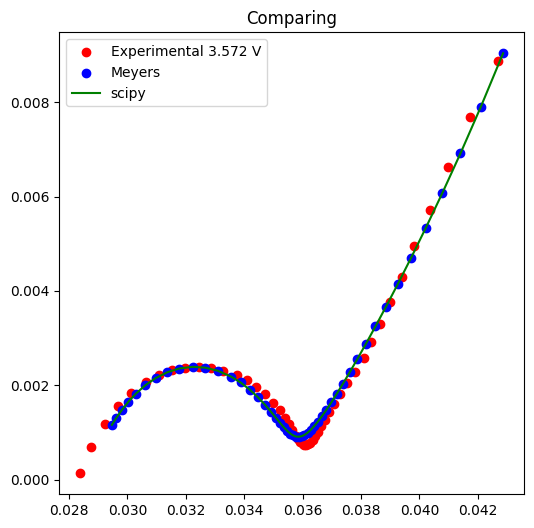

In [ ]:
# Optimizing the difference function for a given data set
def optimize_diff(i):
    # Load the experimental data 
    exp_real = np.array(get_exp_data(i, "")[0][0])
    exp_imag = np.array(get_exp_data(i, "")[0][1])
    frequencies = np.array(get_exp_data(i, "")[1])

    # Difference function for the optimization
    def diff_func(comp, exp_real, exp_imag, frequencies):
        Z = calculate_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff
    
    #print(diff_func(dict_to_list(a_number_parametre), exp_real, exp_imag, frequencies))

    # Convert initial dictionary to list for optimization
    initial_elems = dict_to_list(a_fitting)

    # Optimization options
    options = {
        'maxiter': 10000,    # Maximum number of iterations
        'ftol': 1e-4,       # Function value tolerance
        #'disp': True
    }

    # Minimize the difference function (optimize parameters)
    opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag, frequencies), method='TNC', options=options)
    opt_elems = list_to_dict(a_fitting, opt.x)
    final_diff = diff_func(opt.x, exp_real, exp_imag, frequencies)
    
    #print("Final sum of squared difference for dataset", i, ":", final_diff)

    return opt_elems, final_diff, frequencies, opt.x 

dic_elems, final_diff, frequencies, list_elems = optimize_diff(i)

print(final_diff)
print(dic_elems)
print(a_fitting)

i = 1 

frequencies = np.array(get_exp_data(i, "")[1])
Z = calculate_Z(dict_to_list(a_fitting), frequencies)
Z_scipy = calculate_Z(list_elems, frequencies)

fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z.real, -Z.imag, label = f'Meyers', color = 'blue')
ax.plot(Z_scipy.real, -Z_scipy.imag, label = f'scipy', color = 'green')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

PSO

In [ ]:
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

exp_real = np.array(get_exp_data(1, "")[0][0])
exp_imag = np.array(get_exp_data(1, "")[0][1])
frequencies = np.array(get_exp_data(1, "")[1])

lower_bounds = [0, 0, 0, 0, 0, 0, 0, 1e-20, 0, 1e4, ] 
upper_bounds = [0.002, 0.03, 0.03, 3, 3, 1, 1, 1e-15, 1, 1e8] 
bounds = (lower_bounds, upper_bounds)

initial_elems = dict_to_list(a_fitting)

def diff_func(comp, exp_real, exp_imag, frequencies):
        Z = calculate_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff

def wrapped_diff_function(params):
    return np.array([diff_func(param_set, exp_real, exp_imag, frequencies) for param_set in params])

n_dim = 10 # changing 10 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=200, dimensions=n_dim, options=options, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=200)
print(best_params)


2024-11-26 19:08:44,829 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.000153
2024-11-26 19:08:50,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0001530787431442297, best pos: [1.91262621e-03 6.04939373e-03 2.35278865e-02 3.09927782e-01
 1.61932352e+00 1.26642372e-01 5.33694358e-01 5.89070553e-16
 4.93832595e-01 4.72824368e+07]


[1.91262621e-03 6.04939373e-03 2.35278865e-02 3.09927782e-01
 1.61932352e+00 1.26642372e-01 5.33694358e-01 5.89070553e-16
 4.93832595e-01 4.72824368e+07]


Fredrik's basinhopping

In [ ]:
exp_real = np.array(get_exp_data(1, "")[0][0])
exp_imag = np.array(get_exp_data(1, "")[0][1])
frequencies = np.array(get_exp_data(1, "")[1])

lower_bounds = [0, 0, 0, 0, 0, 0, 0, 1e-20, 0, 1e3] 
upper_bounds = [0.03, 0.1, 0.1,  5, 5, 1, 1, 1e-10, 1, 1e8] 
bounds = list(zip(lower_bounds, upper_bounds))
#bounds_values = (lower_bounds, upper_bounds)
#bounds = [bounds_values] * len(dict_to_list(a_fitting)),
#bounds = tuple(bounds)


initial_elems = dict_to_list(a_fitting)

def diff_func(x0, exp_real, exp_imag, frequencies):
        Z = calculate_Z(x0, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff

sol = basinhopping(diff_func, x0=initial_elems, niter=200, T=1, stepsize=0.2, minimizer_kwargs={'method':'slsqp', 'args':(exp_real, exp_imag, frequencies), 'bounds':bounds, 'tol':10**-6}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
sol_elems = list_to_dict(a_fitting, sol.x)
print(sol_elems)

basinhopping step 0: f 7.89982e-06
basinhopping step 1: f 7.89982e-06 trial_f 40.6432 accepted 0  lowest_f 7.89982e-06
basinhopping step 2: f 7.89982e-06 trial_f 7.19252 accepted 0  lowest_f 7.89982e-06
basinhopping step 3: f 7.89982e-06 trial_f 7.24631 accepted 0  lowest_f 7.89982e-06
basinhopping step 4: f 7.89982e-06 trial_f 7.45532 accepted 0  lowest_f 7.89982e-06
basinhopping step 5: f 7.89982e-06 trial_f 2.75285 accepted 0  lowest_f 7.89982e-06
basinhopping step 6: f 7.89982e-06 trial_f 28.5554 accepted 0  lowest_f 7.89982e-06
basinhopping step 7: f 7.89982e-06 trial_f 85.5858 accepted 0  lowest_f 7.89982e-06
basinhopping step 8: f 7.89982e-06 trial_f 12.1099 accepted 0  lowest_f 7.89982e-06
basinhopping step 9: f 7.89982e-06 trial_f 0.0156283 accepted 0  lowest_f 7.89982e-06
basinhopping step 10: f 7.89982e-06 trial_f 80.534 accepted 0  lowest_f 7.89982e-06
basinhopping step 11: f 7.89982e-06 trial_f 0.0211077 accepted 0  lowest_f 7.89982e-06
basinhopping step 12: f 7.89982e-06 

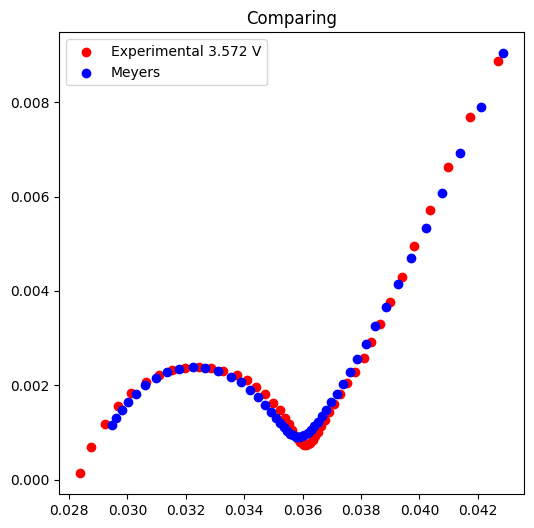

In [ ]:
frequencies = np.array(get_exp_data(i, "")[1])
Z = calculate_Z(dict_to_list(a_fitting), frequencies)
Z_pso = calculate_Z(best_params, frequencies)
Z_Fbasin = calculate_Z(sol.x, frequencies)

fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z.real, -Z.imag, label = f'Meyers', color = 'blue')
#ax.plot(Z_Fbasin.real, -Z_Fbasin.imag, label = f'Fredrik basinhopping', color = 'green')
#ax.plot(Z_pso.real, -Z_pso.imag, label = f'pso', color = 'grey')


#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 